# Tutorial

Welcome to this tutorial on using OpenFLASH! This guide demonstrates how to set up a multi-body hydrodynamic problem, run the simulation engine, and analyze the results.

OpenFLASH uses the **Matched Eigenfunction Expansion Method (MEEM)** to efficiently analyze wave interactions with concentric structures, providing key hydrodynamic insights like added mass, damping, and potential fields.

---

## 1. Prerequisites and Setup

Before you begin, make sure you have installed the `openflash` package. If you haven't, you can install it using `pip`. It's highly recommended to do this within a virtual environment.

```bash
# Install the package from your local project directory
pip install open-flash

In [21]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

<class 'module'>
['/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash']
/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash/__init__.py
OpenFLASH modules imported successfully!


---

## 2. Defining the Problem Geometry

We'll start by defining the physical layout of our problem. The core idea is to create `SteppedBody` objects that represent the physical structures. For this example, we'll simulate **two concentric bodies**.

* **h**: Total water depth.
* **a\_list**: A list of outer radii for each physical body.
* **d\_list**: A list of submerged depths for each body's step.
* **heaving\_list**: A list of boolean flags (`True`/`False`) indicating if each body is heaving.
* **NMK**: The number of harmonics to use in the series expansion for each fluid domain (this will be `number of bodies + 1`).

In [22]:
# ---------------------------------
# --- 1. Problem Setup ---
# ---------------------------------
print("\n--- 1. Setting up the Problem ---")
h = 1.001            # Water Depth (m)
d_list = [0.5, 0.25]   # Step depths (m) for inner and outer bodies
a_list = [0.5, 1.0]    # Radii (m) for inner and outer bodies
heaving_list = [True, False] # Heaving flags for each body
NMK = [30, 30, 30]     # Harmonics for inner, middle, and exterior domains

m0 = 1.0    # Non-dimensional wave number
problem_omega = omega(m0, h, g)
print(f"Wave number (m0): {m0}, Angular frequency (omega): {problem_omega:.4f}")


--- 1. Setting up the Problem ---
Wave number (m0): 1.0, Angular frequency (omega): 2.7341


### Create Geometry and MEEM Problem Instances

Now, we use these parameters to build our geometry in a structured, object-oriented way.

In [24]:
# 1. Create a list of SteppedBody objects
bodies = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]), # Assuming flat tops
        heaving=heaving_list[i]
    )
    bodies.append(body)

# 2. Group the bodies into an arrangement
arrangement = ConcentricBodyGroup(bodies)

# 3. Create a concrete Geometry instance
geometry = BasicRegionGeometry(
    body_arrangement=arrangement,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem = MEEMProblem(geometry)

# 5. Set the frequencies for the problem
problem_frequencies = np.array([problem_omega])
problem.set_frequencies(problem_frequencies)
problem_modes = problem.modes # Get modes from geometry

print("Geometry and MEEM Problem initialized.")
print(f"Problem configured with {len(problem.frequencies)} frequency(ies) and {len(problem.modes)} mode(s): {problem_modes}.")

Geometry and MEEM Problem initialized.
Problem configured with 1 frequency(ies) and 1 mode(s): [0].


---

## 3. Running the MEEM Engine

The `MEEMEngine` orchestrates the entire simulation. We initialize it with our problem and call the appropriate methods to solve the system. For a single frequency, we use `solve_linear_system_multi`.

In [25]:
# 6. Initialize the MEEM Engine
engine = MEEMEngine(problem_list=[problem])
print("MEEMEngine initialized.")

# ---------------------------------
# --- WORKFLOW 1: Single Solve & Plot ---
# ---------------------------------
print("\n--- WORKFLOW 1: Solving for a single frequency ---")

# Solve the linear system. 
# This one high-level call handles everything:
# 1. Calls _ensure_m_k_and_N_k_arrays
# 2. Calls assemble_A_multi
# 3. Calls assemble_b_multi
# 4. Solves the system for X
X = engine.solve_linear_system_multi(problem, m0)

print(f"Linear system solved. Solution vector X shape: {X.shape}")

MEEMEngine initialized.

--- WORKFLOW 1: Solving for a single frequency ---
Linear system solved. Solution vector X shape: (120,)


---

## 4. Analyzing and Visualizing Results

With the solution vector `X`, we can now compute and visualize the physical results. 

### Hydrodynamic Coefficients

The engine can compute the added mass and damping coefficient matrices from the solution vector.

In [33]:
# --- Get Coefficients from X ---
hydro_coefficients = engine.compute_hydrodynamic_coefficients(problem, X, m0)

if hydro_coefficients:
    df_coeffs = pd.DataFrame(hydro_coefficients)
    print("\nCalculated Hydrodynamic Coefficients:")
    print(df_coeffs)
else:
    print("Hydrodynamic coefficients could not be calculated.")


Calculated Hydrodynamic Coefficients:
   mode        real        imag  nondim_real  nondim_imag  excitation_phase  \
0     0  288.978396  189.013785     0.719333     0.172085         -0.521015   

   excitation_force  
0         63.330565  


### Potential Field Visualization 

Next, we'll calculate the potential field over a 2D spatial grid and visualize it.


Coefficients reformatted into 3 regions.
  Region 0 (NMK=30): (30,) coefficients
  Region 1 (NMK=30): (60,) coefficients
  Region 2 (NMK=30): (30,) coefficients

Calculating potential fields for visualization...


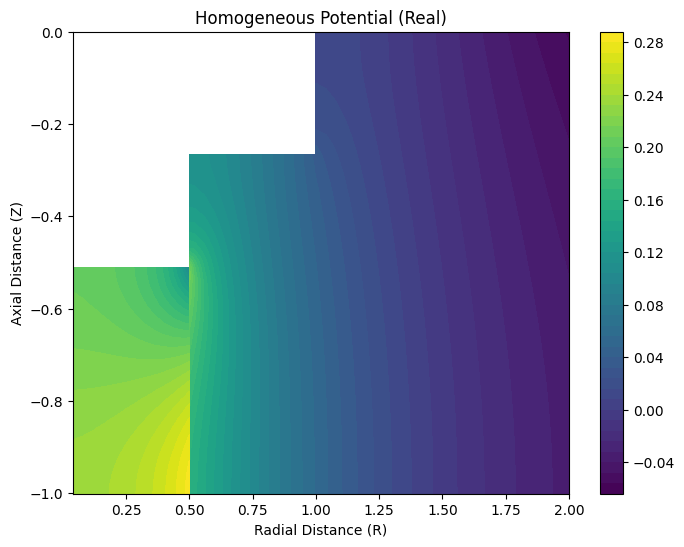

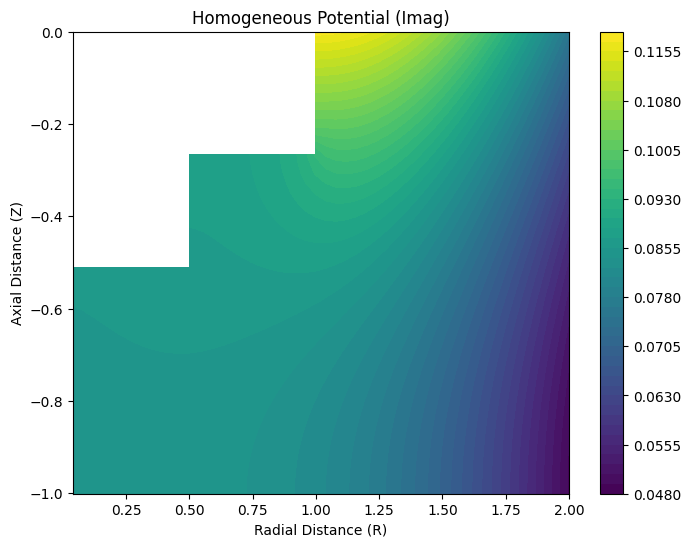

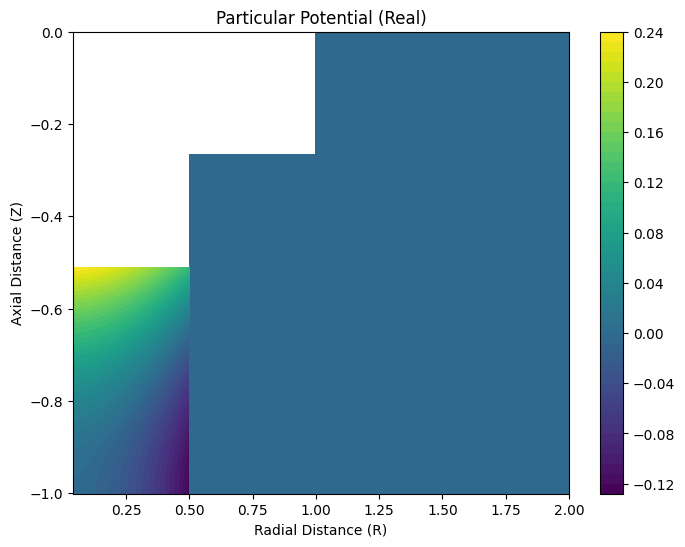

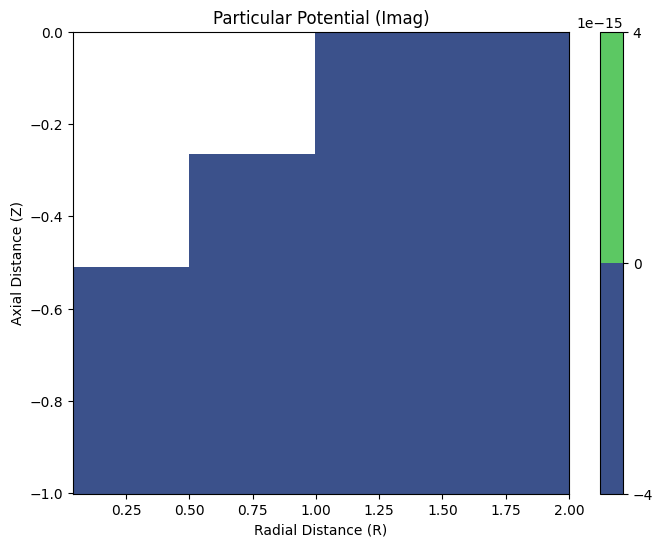

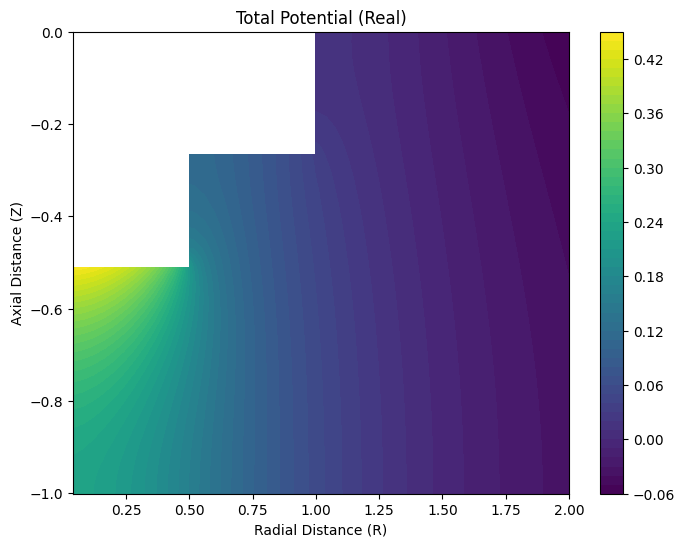

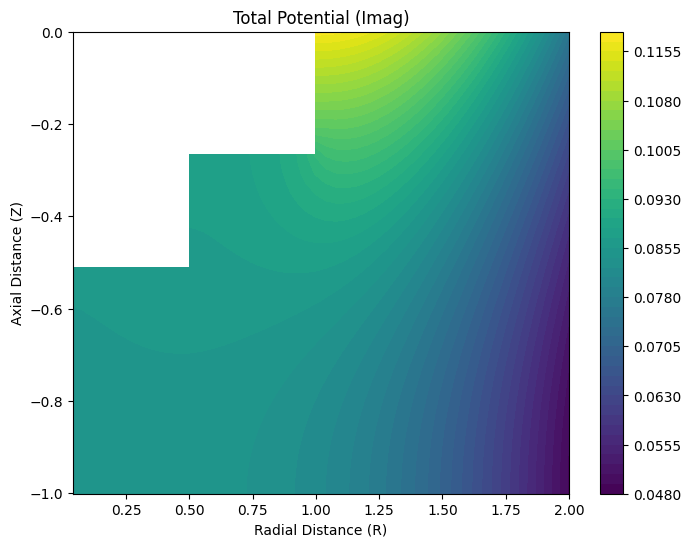

In [28]:
# --- Reformat coefficients (for plotting) ---
boundary_count = len(NMK) - 1
Cs = engine.reformat_coeffs(X, NMK, boundary_count)
print(f"\nCoefficients reformatted into {len(Cs)} regions.")
for i, c_region in enumerate(Cs):
    print(f"  Region {i} (NMK={NMK[i]}): {c_region.shape} coefficients")
        
# --- Calculate and Plot Potentials from X ---
print("\nCalculating potential fields for visualization...")
potentials = engine.calculate_potentials(problem, X, m0, spatial_res=50, sharp=True)

# Unpack
R = potentials["R"]
Z = potentials["Z"]
phiH = potentials["phiH"]
phiP = potentials["phiP"]
phi = potentials["phi"]

# --- Plot using built-in visualizer ---
engine.visualize_potential(np.real(phiH), R, Z, "Homogeneous Potential (Real)")
engine.visualize_potential(np.imag(phiH), R, Z, "Homogeneous Potential (Imag)")
engine.visualize_potential(np.real(phiP), R, Z, "Particular Potential (Real)")
engine.visualize_potential(np.imag(phiP), R, Z, "Particular Potential (Imag)")
engine.visualize_potential(np.real(phi), R, Z, "Total Potential (Real)")
engine.visualize_potential(np.imag(phi), R, Z, "Total Potential (Imag)")
        
plt.show()

## 5. Saving Results to NetCDF

The `Results` class is used to store all simulation ou `xarray.Dataset` and export them to a file. This is especially useful after running a frequency sweep.

In [ ]:
# ---------------------------------
# --- WORKFLOW 2: Full Sweep & Storage ---
# ---------------------------------
# This workflow is best for running multiple frequencies
# and saving all results to a file.
print("\n--- WORKFLOW 2: Running a full sweep to store results ---")

# We already set the frequency on the 'problem' object.
# 'run_and_store_results' will solve for all frequencies
# defined in the problem list (in this case, just one).
results_obj = engine.run_and_store_results(problem_index=0)

# Export the entire dataset to a NetCDF file
file_path = "meem_simulation_results.nc"
results_obj.export_to_netcdf(file_path)
print(f"All results successfully saved to '{file_path}'")

# Inspect the final xarray Dataset
print("\nContents of the final xarray Dataset:")
print(results_obj.get_results())


--- WORKFLOW 2: Running a full sweep to store results ---
Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).
All results successfully saved to 'meem_simulation_results.nc'

Contents of the final xarray Dataset:
<xarray.Dataset> Size: 6kB
Dimensions:             (frequency: 1, mode_i: 1, mode_j: 1, harmonics: 60,
                         domain_name: 3, modes: 1)
Coordinates:
  * frequency           (frequency) float64 8B 2.734
  * mode_i              (mode_i) int64 8B 0
  * mode_j              (mode_j) int64 8B 0
  * harmonics           (harmonics) int64 480B 0 1 2 3 4 5 ... 54 55 56 57 58 59
  * domain_name         (domain_name) int64 24B 0 1 2
  * modes               (modes) int64 8B 0
Data variables:
    added_mass          (frequency, mode_i, mode_j) float64 8B 289.0
    damping             (frequency, mode_i, mode_j) float64 8B 189.0
    potentials_real     (frequency, modes, domain_name, harmonics) float64 


--- WORKFLOW 3: Frequency Sweep & Coefficient Plotting ---
Setting up 2-body problem for sweep...
Sweep problem configured with 40 frequencies and 2 modes: [0 1].
Running frequency sweep... (This may take a moment)
Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).
Sweep complete.
Extracting data and plotting coefficients...


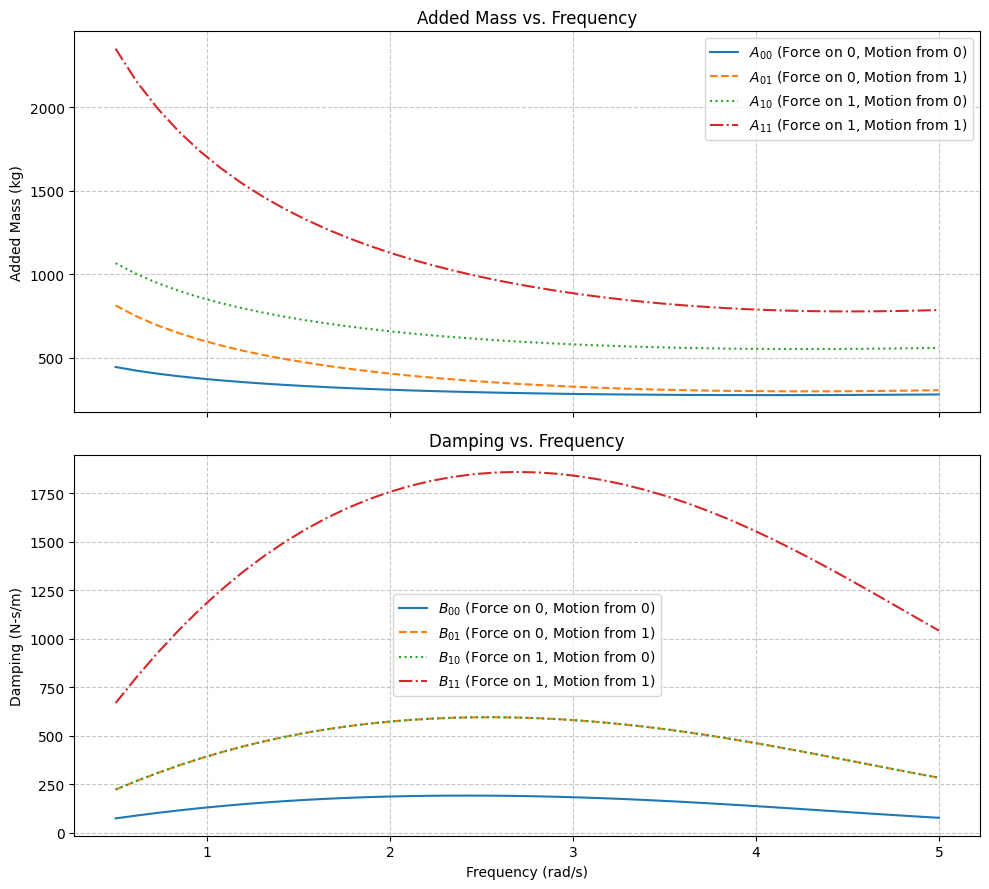


Tutorial finished.


In [ ]:
# ---------------------------------
# --- WORKFLOW 3: Frequency Sweep & Coefficient Plotting ---
# ---------------------------------
# This workflow shows a common use case:
# 1. Define a problem where *all* bodies can move (heaving=[True, True])
# 2. Run a sweep over a range of frequencies.
# 3. Plot the resulting 2x2 Added Mass and Damping matrices.

print("\n--- WORKFLOW 3: Frequency Sweep & Coefficient Plotting ---")

# --- 3.1. Define the Problem for a Full 2-Body Sweep ---
# We define the problem so that *both* bodies are
# included as active modes (degrees of freedom).
print("Setting up 2-body problem for sweep...")

# Use the same geometric parameters from Section 1
h = 1.001            
d_list = [0.5, 0.25]
a_list = [0.5, 1.0]
NMK = [30, 30, 30]

# --- KEY CHANGE ---
# Set heaving to [True, True] so that problem.modes becomes [0, 1].
# This tells run_and_store_results to solve the full 2x2 N-body problem.
heaving_list_sweep = [True, True] 

# 1. Create SteppedBody objects
bodies_sweep = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]),
        heaving=heaving_list_sweep[i]
    )
    bodies_sweep.append(body)

# 2. Create arrangement
arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

# 3. Create geometry
geometry_sweep = BasicRegionGeometry(
    body_arrangement=arrangement_sweep,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem_sweep = MEEMProblem(geometry_sweep)

# 5. Set the frequencies for the sweep
# We will run for 40 frequencies from 0.5 to 5.0 rad/s
omega_sweep = np.linspace(0.5, 5.0, 40)
problem_sweep.set_frequencies(omega_sweep)

print(f"Sweep problem configured with {len(problem_sweep.frequencies)} frequencies and {len(problem_sweep.modes)} modes: {problem_sweep.modes}.")

# 6. Initialize a new MEEM Engine for this problem
engine_sweep = MEEMEngine(problem_list=[problem_sweep])

# --- 3.2. Run the Full Sweep ---
print("Running frequency sweep... (This may take a moment)")
# This one call solves the radiation problem for each mode (0 and 1)
# at each of the 40 frequencies.
results_obj_sweep = engine_sweep.run_and_store_results(problem_index=0)
print("Sweep complete.")

# --- 3.3. Extract and Plot Hydrodynamic Coefficients ---
print("Extracting data and plotting coefficients...")

# Get the xarray.Dataset
ds_sweep = results_obj_sweep.get_results()

# Extract the Added Mass and Damping matrices.
# These are 3D arrays: (frequency, mode_j, mode_i)
# A[freq, 1, 0] = Added Mass on body 1 due to motion of body 0
A_sweep = ds_sweep.added_mass
B_sweep = ds_sweep.damping
freqs_out = ds_sweep.frequency # This is the same as omega_sweep

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

# --- Plot 1: Added Mass ---
ax1.plot(freqs_out, A_sweep[:, 0, 0], label=r'$A_{00}$ (Force on 0, Motion from 0)')
ax1.plot(freqs_out, A_sweep[:, 0, 1], label=r'$A_{01}$ (Force on 0, Motion from 1)', linestyle='--')
ax1.plot(freqs_out, A_sweep[:, 1, 0], label=r'$A_{10}$ (Force on 1, Motion from 0)', linestyle=':')
ax1.plot(freqs_out, A_sweep[:, 1, 1], label=r'$A_{11}$ (Force on 1, Motion from 1)', linestyle='-.')
ax1.set_ylabel('Added Mass (kg)')
ax1.set_title('Added Mass vs. Frequency')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# --- Plot 2: Damping ---
ax2.plot(freqs_out, B_sweep[:, 0, 0], label=r'$B_{00}$ (Force on 0, Motion from 0)')
ax2.plot(freqs_out, B_sweep[:, 0, 1], label=r'$B_{01}$ (Force on 0, Motion from 1)', linestyle='--')
ax2.plot(freqs_out, B_sweep[:, 1, 0], label=r'$B_{10}$ (Force on 1, Motion from 0)', linestyle=':')
ax2.plot(freqs_out, B_sweep[:, 1, 1], label=r'$B_{11}$ (Force on 1, Motion from 1)', linestyle='-.')
ax2.set_ylabel('Damping (N-s/m)')
ax2.set_title('Damping vs. Frequency')
ax2.set_xlabel('Frequency (rad/s)')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


print("\nTutorial finished.")

## 6. Conclusion

This tutorial has walked you through the modern, object-oriented workflow for running a simulation with OpenFLASH. You've learned how to:

* Define a physical problem using `SteppedBody` objects.
* Initialize and execute the `MEEMEngine` to solve for the system's coefficients.
* Extract and view hyrdodynamic coefficients.
* Calculate and visualzie the spatial potential field.
* Store all simulation results in a structured `Results` object and export to NetCDF.

For more detailed information on specific classes and functions, please refer to the project's Sphinx documentation.

Feel free to experiment with different parameters and geometries to explore various hydrodynamic scenarios!